# Demo Similarity

**Base Model**

* era5

**CMIP5 Models**:
* "inmcm4",
* "access1_0",
* "bcc_csm1_1",
* "bcc_csm1_1_m",
* "bnu_esm",
* "cnrm_cm5",
* "ec_earth",
* "fgoals_s2",
* "ipsl_cm5b_lr",
* "mpi_esm_lr",
* "mpi_esm_mr"

In [12]:
import sys, os
from pyprojroot import here

# spyder up to find the root
isp_root = "/home/emmanuel/code/isp_data"
root = here(project_files=[".here"])

# append to path
sys.path.append(str(root))
sys.path.append(str(isp_root))

from pathlib import Path
# 
import cdsapi
import xarray as xr
from pprint import pprint
import cftime
import xesmf as xe
from isp_data.esdc.temporal import convert_to_360day_monthly


# MATPLOTLIB Settings
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# SEABORN SETTINGS
import seaborn as sns
sns.set_context(context='talk',font_scale=0.7)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Data

In [4]:
DATASET_DIR = f"{root}/datasets/"
DATASET_DIR

'/home/emmanuel/projects/rbig4eo/datasets/'

In [10]:
cmip_glob = Path(DATASET_DIR).joinpath("cmip5").glob(f"*.nc")
era5_glob = Path(DATASET_DIR).joinpath("era5").glob(f"*.nc")
nc_files = [
    str(x) for x in cmip_glob if x.is_file()
] + [
    str(x) for x in era5_glob if x.is_file()
]
nc_files

['/home/emmanuel/projects/rbig4eo/datasets/cmip5/psl_Amon_inmcm4_rcp85_r1i1p1_200601-210012.nc',
 '/home/emmanuel/projects/rbig4eo/datasets/cmip5/psl_Amon_BNU-ESM_rcp85_r1i1p1_200601-210012.nc',
 '/home/emmanuel/projects/rbig4eo/datasets/cmip5/psl_Amon_IPSL-CM5B-LR_rcp85_r1i1p1_200601-210012.nc',
 '/home/emmanuel/projects/rbig4eo/datasets/cmip5/psl_Amon_MPI-ESM-MR_rcp85_r1i1p1_200601-210012.nc',
 '/home/emmanuel/projects/rbig4eo/datasets/cmip5/psl_Amon_ACCESS1-0_rcp85_r1i1p1_200601-210012.nc',
 '/home/emmanuel/projects/rbig4eo/datasets/cmip5/psl_Amon_MPI-ESM-LR_rcp85_r1i1p1_200601-210012.nc',
 '/home/emmanuel/projects/rbig4eo/datasets/era5/mslp_era5.nc']

In [26]:
DATASET_DIR = f"{root}/datasets/"
TIME_SLICE = slice("202001", "202012")
BASE_GRID_MODEL = "ipsl_cm5b_lr"


# =====================
# LOAD DATA
# =====================

cmip_glob = Path(DATASET_DIR).joinpath("cmip5").glob(f"*.nc")
era5_glob = Path(DATASET_DIR).joinpath("era5").glob(f"*.nc")
nc_files = [str(x) for x in cmip_glob if x.is_file()] + [
    str(x) for x in era5_glob if x.is_file()
]


ds = {}
for ifile in nc_files:
    # manually set the encoding to use cftime
    i_ds = xr.open_dataset(ifile, decode_times=True, use_cftime=True)

    # assign a new coordinate name
    try:
        model_id = i_ds.model_id.lower().replace("-", "_")

    except:
        model_id = "era5"
        i_ds = i_ds.rename({"msl": "psl", "latitude": "lat", "longitude": "lon"})
    i_ds = i_ds.assign_coords({"model_id": model_id})
    # create the same calendar
    i_ds = convert_to_360day_monthly(i_ds, False)

    # move attributes to new coordinate
    i_ds.model_id.attrs = i_ds.attrs
    i_ds.attrs = {}

    ds[model_id] = i_ds


In [27]:
# =====================
# Select Time Slice
# =====================
for imodel_id, ids in ds.items():
    ds[imodel_id] = ds[imodel_id].sel(time=TIME_SLICE)

n_time = ds[imodel_id]["time"].values.shape[0]

In [28]:
# =====================
# REGRID
# =====================
ds_out = xr.Dataset(
    {
        "lat": (["lat"], ds[BASE_GRID_MODEL].lat),
        "lon": (["lon"], ds[BASE_GRID_MODEL].lon),
    }
)

n_lat = ds_out.coords["lat"].values.shape[0]
n_lon = ds_out.coords["lon"].values.shape[0]

final_ds = []

for imodel_id, ids in ds.items():
    if imodel_id == "ipsl_cm5b_lr":
        t = ids.psl
        t.attrs = ids.attrs
        final_ds.append(t)
        continue

    regridder = xe.Regridder(ids, ds_out, "nearest_s2d")
    t = regridder(ids["psl"])
    t.attrs = ids.attrs
    final_ds.append(t)

final_ds = xr.concat(final_ds, dim="model_id").reset_coords()

In [29]:
final_ds.coords["model_id"].values

array(['inmcm4', 'bnu_esm', 'ipsl_cm5b_lr', 'mpi_esm_mr', 'access1_0',
       'mpi_esm_lr', 'era5'], dtype='<U12')

In [88]:
# =====================
# PEARSON CORRELATION
# =====================

import pandas as pd

all_stats = pd.DataFrame()
from scipy.stats import pearsonr

# get all model IDS
model_ids = final_ds.coords["model_id"].values
sym_pairs = [pair for pair in itertools.combinations(model_ids, 2)]

import tqdm
import numpy as np

with tqdm.tqdm(sym_pairs) as pbar:

    for i, imodel_pair in enumerate(pbar):
        
        imodel_stats = {"model_0": imodel_pair[0], "model_1": imodel_pair[1]}

        pbar.set_description(f"Model 1: {imodel_pair[0]}, Model 2: {imodel_pair[1]}")

        # select model
        ids = final_ds.sel(model_id=[imodel_pair[0], imodel_pair[1]]).psl.values


        # calculate pearson correlation
        pbar.set_description(f"Calculating Correlation...")
        
        x = np.reshape(ids[0], (n_lat * n_lon * n_time))
        y = np.reshape(ids[1], (n_lat * n_lon * n_time))

        prs_r = pearson(x, y)
        
        imodel_stats = {**imodel_stats, **prs_r}
        
        
        # calculate pearson correlation
        pbar.set_description(f"Calculating RV Coeff...")
        
        X = np.reshape(ids[0], (n_lat * n_lon, n_time))
        Y = np.reshape(ids[1], (n_lat * n_lon, n_time))
        rv = rv_coefficient(X, Y)
        
        imodel_stats = {**imodel_stats, **rv}
        
        # calculate pearson correlation
        pbar.set_description(f"Calculating nHSIC Coeff...")
        
        nhsic = cka_coefficient(X, Y)
        
        imodel_stats = {**imodel_stats, **nhsic}
        
        all_stats = pd.concat([all_stats, pd.DataFrame(imodel_stats, index=[i])], axis=0)

Calculating nHSIC Coeff...: 100%|██████████| 21/21 [07:02<00:00, 20.10s/it]                


In [89]:
all_stats

,model_0,model_1,pearson,x_std,y_std,rv_coef,x_norm,y_norm,xy_norm,cka_coeff,cka_y_norm,cka_x_norm,cka_xy_norm
0,inmcm4,bnu_esm,0.713392,1066.494716,1241.193674,0.525760,1.184638e+11,1.649051e+11,1.027087e+22,0.525760,0.002062,0.002543,2.756948e-06
1,inmcm4,ipsl_cm5b_lr,0.593819,1066.494716,1636.617173,0.350334,1.184638e+11,2.729027e+11,1.132599e+22,0.350334,0.003939,0.002543,3.509561e-06
2,inmcm4,mpi_esm_mr,0.672918,1066.494716,1037.069109,0.467147,1.184638e+11,1.133496e+11,6.272773e+21,0.467147,0.002611,0.002543,3.102582e-06
3,inmcm4,access1_0,0.660732,1066.494716,1169.235819,0.454143,1.184638e+11,1.461976e+11,7.865352e+21,0.454143,0.002722,0.002543,3.144027e-06
4,inmcm4,mpi_esm_lr,0.763364,1066.494716,966.900659,0.604657,1.184638e+11,9.791680e+10,7.013780e+21,0.604657,0.002724,0.002543,4.188984e-06
5,inmcm4,era5,0.830533,1066.494716,1122.984655,0.711749,1.184638e+11,1.338248e+11,1.128364e+22,0.711749,0.003841,0.002543,6.953223e-06
6,bnu_esm,ipsl_cm5b_lr,0.287756,1241.193674,1636.617173,0.080147,1.649051e+11,2.729027e+11,3.606862e+21,0.080148,0.003939,0.002062,6.508667e-07
7,bnu_esm,mpi_esm_mr,0.762589,1241.193674,1037.069109,0.601649,1.649051e+11,1.133496e+11,1.124598e+22,0.601649,0.002611,0.002062,3.239241e-06
8,bnu_esm,access1_0,0.756031,1241.193674,1169.235819,0.588201,1.649051e+11,1.461976e+11,1.418079e+22,0.588201,0.002722,0.002062,3.301040e-06
9,bnu_esm,mpi_esm_lr,0.707299,1241.193674,966.900659,0.517607,1.649051e+11,9.791680e+10,8.357795e+21,0.517607,0.002724,0.002062,2.906904e-06


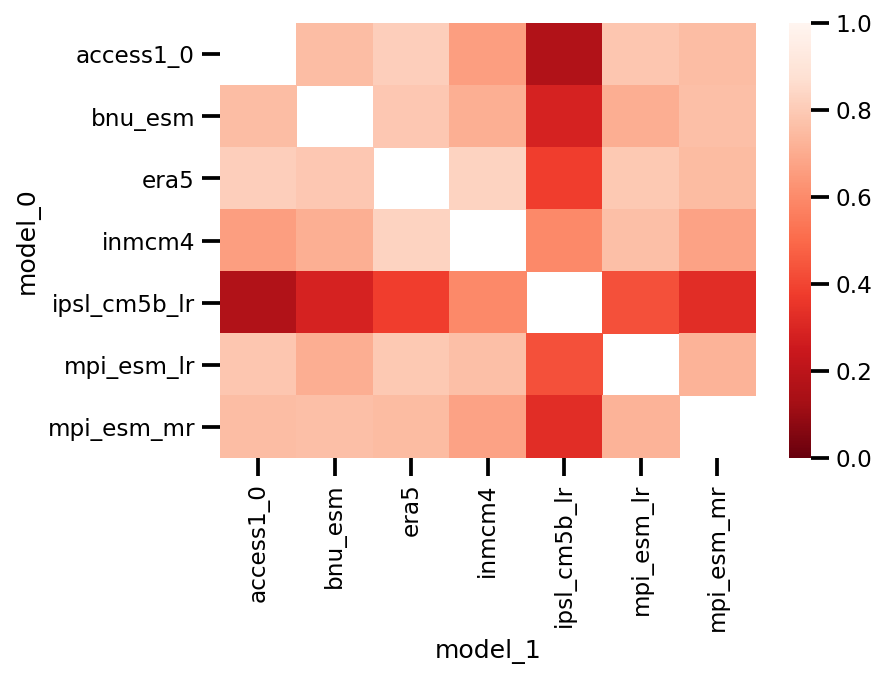

In [102]:
t = all_stats[["model_0", "model_1", "pearson"]]
t = pd.concat([t, t.rename(columns={"model_0": "model_1", "model_1": "model_0"})], axis=0).drop_duplicates()
t = t.pivot("model_0", "model_1", "pearson")

ax = sns.heatmap(t, vmin=0, vmax=1.0, cmap='Reds_r')

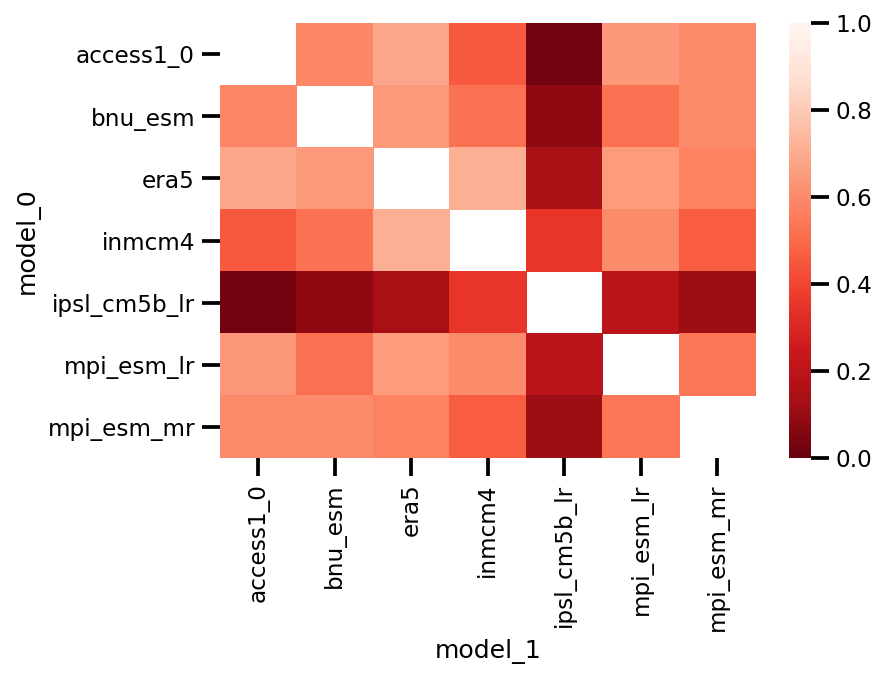

In [103]:
t = all_stats[["model_0", "model_1", "rv_coef"]]
t = pd.concat([t, t.rename(columns={"model_0": "model_1", "model_1": "model_0"})], axis=0).drop_duplicates()
t = t.pivot("model_0", "model_1", "rv_coef")

ax = sns.heatmap(t, vmin=0, vmax=1.0, cmap='Reds_r')

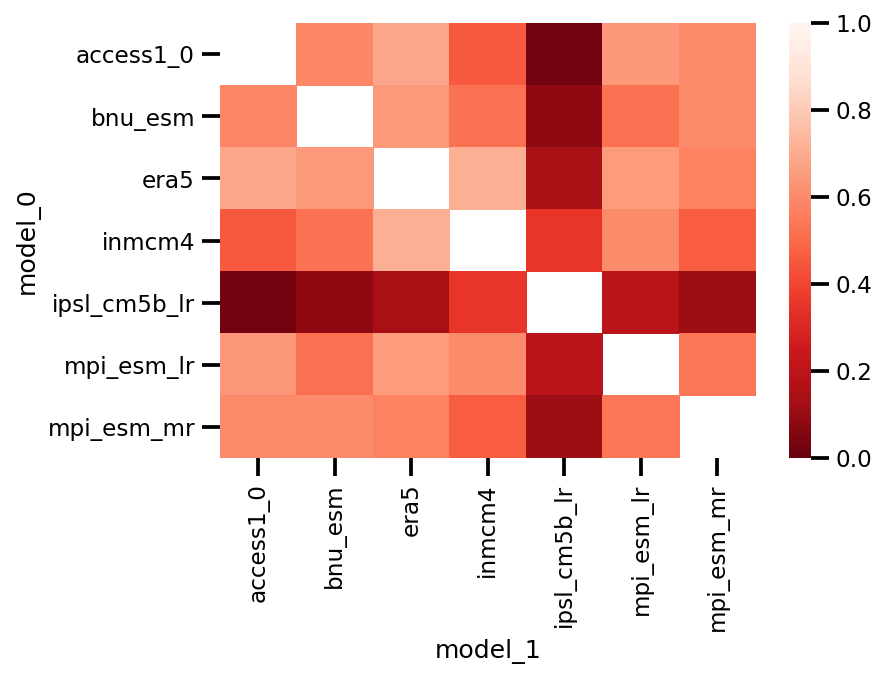

In [104]:
t = all_stats[["model_0", "model_1", "cka_coeff"]]
t = pd.concat([t, t.rename(columns={"model_0": "model_1", "model_1": "model_0"})], axis=0).drop_duplicates()
t = t.pivot("model_0", "model_1", "cka_coeff")

ax = sns.heatmap(t, vmin=0, vmax=1.0, cmap='Reds_r')

In [115]:
import scipy.cluster.hierarchy as spc
pdist = 1 - np.abs(t.values)
pdist = pdist[np.triu_indices_from(pdist, k=1)]
linkage = spc.linkage(pdist, method="complete", optimal_ordering=True)
order = spc.leaves_list(linkage)

name_corrections = {
    "access1_0": "ACCESS1.0",
    "bnu_esm": "BNU ESM",
    "era5": "ERA5",
    "inmcm4": "INMCM4",
    "ipsl_cm5b_lr": "IPSL-CM5B-LR",
    "mpi_esm_lr": "MPI-ESM-LR",
    "mpi_esm_mr": "MPI-ESM-MR",
}
names = [i for i in name_corrections.values()]
# def names(i):
#     return name_corrections

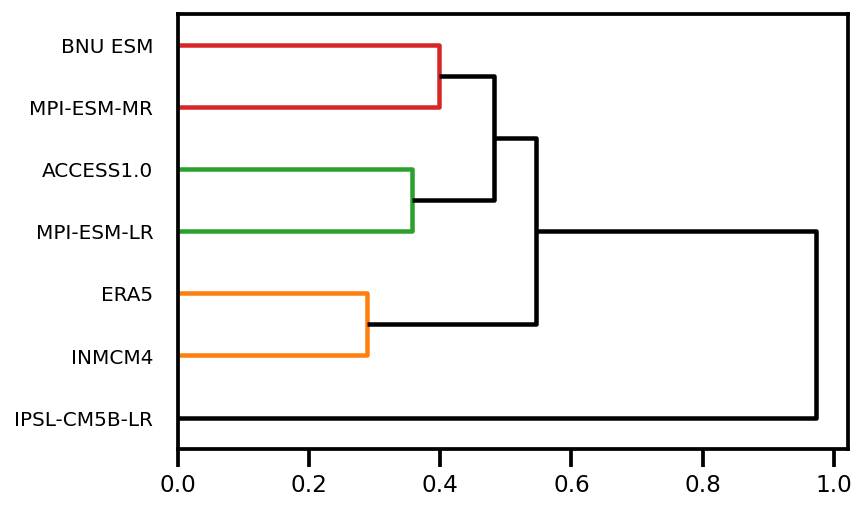

In [116]:
d = spc.dendrogram(
        linkage,
        above_threshold_color="k",
        color_threshold=0.4,
        orientation="right",
        leaf_label_func=lambda i: names[i],
        leaf_font_size=10,
        leaf_rotation=0,
    )

In [ ]:
all_pairs = [pair for pair in itertools.product(model_ids, model_ids)]

grid_size =

for im, jm in all_pairs

In [ ]:
from src.models.univariate import univariate_stats, pearson
from src.models.kernels import rv_coefficient, cka_coefficient

In [47]:
model_ids

array(['inmcm4', 'bnu_esm', 'ipsl_cm5b_lr', 'mpi_esm_mr', 'access1_0',
       'mpi_esm_lr', 'era5'], dtype='<U12')

In [56]:
[pair for pair in itertools.product(model_ids, model_ids)]

[('inmcm4', 'inmcm4'),
 ('inmcm4', 'bnu_esm'),
 ('inmcm4', 'ipsl_cm5b_lr'),
 ('inmcm4', 'mpi_esm_mr'),
 ('inmcm4', 'access1_0'),
 ('inmcm4', 'mpi_esm_lr'),
 ('inmcm4', 'era5'),
 ('bnu_esm', 'inmcm4'),
 ('bnu_esm', 'bnu_esm'),
 ('bnu_esm', 'ipsl_cm5b_lr'),
 ('bnu_esm', 'mpi_esm_mr'),
 ('bnu_esm', 'access1_0'),
 ('bnu_esm', 'mpi_esm_lr'),
 ('bnu_esm', 'era5'),
 ('ipsl_cm5b_lr', 'inmcm4'),
 ('ipsl_cm5b_lr', 'bnu_esm'),
 ('ipsl_cm5b_lr', 'ipsl_cm5b_lr'),
 ('ipsl_cm5b_lr', 'mpi_esm_mr'),
 ('ipsl_cm5b_lr', 'access1_0'),
 ('ipsl_cm5b_lr', 'mpi_esm_lr'),
 ('ipsl_cm5b_lr', 'era5'),
 ('mpi_esm_mr', 'inmcm4'),
 ('mpi_esm_mr', 'bnu_esm'),
 ('mpi_esm_mr', 'ipsl_cm5b_lr'),
 ('mpi_esm_mr', 'mpi_esm_mr'),
 ('mpi_esm_mr', 'access1_0'),
 ('mpi_esm_mr', 'mpi_esm_lr'),
 ('mpi_esm_mr', 'era5'),
 ('access1_0', 'inmcm4'),
 ('access1_0', 'bnu_esm'),
 ('access1_0', 'ipsl_cm5b_lr'),
 ('access1_0', 'mpi_esm_mr'),
 ('access1_0', 'access1_0'),
 ('access1_0', 'mpi_esm_lr'),
 ('access1_0', 'era5'),
 ('mpi_esm_lr', '

In [90]:
import itertools
all_pairs = [pair for pair in itertools.product(model_ids, model_ids)]
inv_pairs = map(lambda x: tuple(reversed(x)), all_pairs)

all_pairs

[('inmcm4', 'inmcm4'),
 ('inmcm4', 'bnu_esm'),
 ('inmcm4', 'ipsl_cm5b_lr'),
 ('inmcm4', 'mpi_esm_mr'),
 ('inmcm4', 'access1_0'),
 ('inmcm4', 'mpi_esm_lr'),
 ('inmcm4', 'era5'),
 ('bnu_esm', 'inmcm4'),
 ('bnu_esm', 'bnu_esm'),
 ('bnu_esm', 'ipsl_cm5b_lr'),
 ('bnu_esm', 'mpi_esm_mr'),
 ('bnu_esm', 'access1_0'),
 ('bnu_esm', 'mpi_esm_lr'),
 ('bnu_esm', 'era5'),
 ('ipsl_cm5b_lr', 'inmcm4'),
 ('ipsl_cm5b_lr', 'bnu_esm'),
 ('ipsl_cm5b_lr', 'ipsl_cm5b_lr'),
 ('ipsl_cm5b_lr', 'mpi_esm_mr'),
 ('ipsl_cm5b_lr', 'access1_0'),
 ('ipsl_cm5b_lr', 'mpi_esm_lr'),
 ('ipsl_cm5b_lr', 'era5'),
 ('mpi_esm_mr', 'inmcm4'),
 ('mpi_esm_mr', 'bnu_esm'),
 ('mpi_esm_mr', 'ipsl_cm5b_lr'),
 ('mpi_esm_mr', 'mpi_esm_mr'),
 ('mpi_esm_mr', 'access1_0'),
 ('mpi_esm_mr', 'mpi_esm_lr'),
 ('mpi_esm_mr', 'era5'),
 ('access1_0', 'inmcm4'),
 ('access1_0', 'bnu_esm'),
 ('access1_0', 'ipsl_cm5b_lr'),
 ('access1_0', 'mpi_esm_mr'),
 ('access1_0', 'access1_0'),
 ('access1_0', 'mpi_esm_lr'),
 ('access1_0', 'era5'),
 ('mpi_esm_lr', '

In [73]:
len(all_pairs), len(sym_pairs)

(49, 21)

In [53]:
('era5', 'inmcm4') != tuple(reversed(('inmcm4', 'era5')))

False

In [52]:
reversed(('inmcm4', 'era5'))